# Appointment Scheduling
In this case, we look at a scheduling problem. A hospital needs schedule times for patients. Determining the schedule times is not easy. They can not be too early or too late. Otherwise this will result in a waiting time for the patients or the physician.

### Imports

In [184]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
np.random.seed(10)

## A. Appointment Process
Hier moet nog text

In [185]:
def total_waiting_time(patients, arrival, consulting, duetime, include_overtime = True):
    waiting = np.zeros(patients)
    
    
    interarrival = np.zeros(patients-1)
    for i in range(0,patients-1):     
        interarrival[i] = arrival[i+1]-arrival[i]
    
    waiting = np.zeros(patients)
    waiting[0] = -1*min(arrival[0],0)
    
    for i in range(1,patients):
        waiting[i] = max((waiting[i-1]+consulting[i-1]-interarrival[i-1]),0)
    
    if(arrival[patients-1] + waiting[patients-1] + consulting[patients-1] <= 60):
        overtime = 0
    else:
        overtime = arrival[patients-1] + waiting[patients-1] + consulting[patients-1] - duetime

    if include_overtime:
        return np.sum(waiting) + max(overtime, 0) # since no negative overtime
    
    return np.sum(waiting)

patients = 5
arrival = np.array([-1,13,34,42,65])
consulting = np.array([17,12,25,11,22])
duetime = 90
f"Total output: {total_waiting_time(patients, arrival, consulting, duetime)}"

'Total output: 29.0'

## B. Read data files and fit
First we read the data from the files. Then we fit the data using the ```stats``` library. Then we test our fits using a QQ-plot. We also test using the [Kolmogorov–Smirnov test](https://en.wikipedia.org/wiki/Kolmogorov–Smirnov_test). Later nog meer.

(2.2779958110557983, 5.213956145364902, 4.263397347002702)


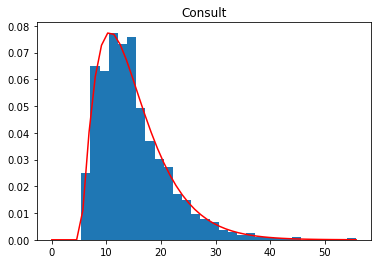

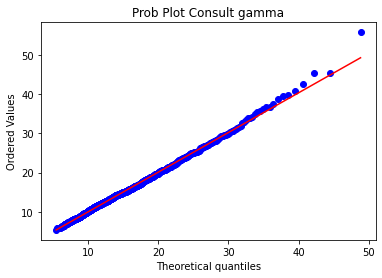

KstestResult(statistic=0.021660296601322182, pvalue=0.7275741242751255)


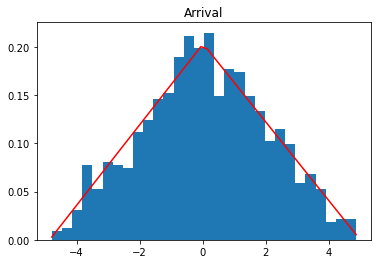

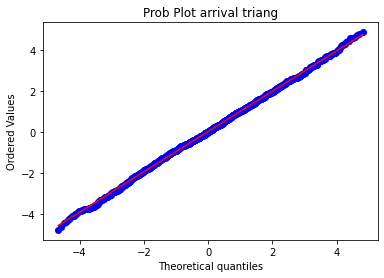

KstestResult(statistic=0.023134722720270617, pvalue=0.649452065976954)


In [186]:
def get_data_and_fit(consult, arrivals):
    paramconsult = stats.gamma.fit(consult)
    
    x = np.linspace(0,np.amax(consult))
    pdf_fit = stats.gamma.pdf(x,*paramconsult)
    print(paramconsult)
    plt.plot(x, pdf_fit, color='r')
    plt.title("Consult")
    plt.hist(consult,density=True, bins=30)
    plt.show()

    stats.probplot(consult, dist=stats.gamma, sparams=paramconsult, plot=plt)
    plt.title("Prob Plot Consult gamma")
    plt.show()
    

    print(stats.kstest(consult, stats.gamma.cdf, args=paramconsult))
    
    paramarrivals = stats.triang.fit(arrivals)
    x = np.linspace(np.amin(arrivals),np.amax(arrivals))
    pdf_fit = stats.triang.pdf(x,*paramarrivals)
    plt.title("Arrival")
    plt.plot(x, pdf_fit, color='r')
    plt.hist(arrivals,density=True,bins=30)
    plt.show()
    
    stats.probplot(arrivals, dist=stats.triang, sparams=paramarrivals, plot=plt)
    plt.title("Prob Plot arrival triang")
    plt.show()

    print(stats.kstest(arrivals, stats.triang.cdf, args=paramarrivals))

    return paramconsult, paramarrivals, consult.mean(), arrivals.mean()

consult = np.genfromtxt("consult_times.txt")
arrivals = np.genfromtxt("delta_arrivals.txt")
p_c, p_a, c_m, a_m = get_data_and_fit(consult, arrivals)

## C. Simulate


In [187]:
def gen_arrival_time(params, n = 18):
    return stats.triang.rvs(params[0], loc=params[1], scale=params[2], size=n)

def gen_consult_time(params, n=18):
    return stats.gamma.rvs(params[0], loc=params[1], scale=params[2], size=n)

def simulate_one(schedule_time, duetime):
    gen_con = gen_consult_time(p_c)
    gen_delta_arr = gen_arrival_time(p_a)
    arrivals = np.zeros(18)
    for i in range(18):
        arrivals[i] = gen_delta_arr[i] + i * schedule_time
    
    return total_waiting_time(18, arrivals, gen_con, duetime, include_overtime=True)

def simulate_all(n, schedule_time, duetime):
    np.random.seed(54372987)
    total_waiting = np.zeros(n)
    for i in range(n):
        total_waiting[i] = simulate_one(schedule_time, duetime)

    mean = total_waiting.mean()
    se = total_waiting.std()/np.sqrt(18)

    return mean, se, (total_waiting.mean() - 1.96 * se, total_waiting.mean() + 1.96 * se)

simulate_all(500, c_m * 1.2, 300)


(101.78444350146508,
 19.779118027992943,
 (63.01737216659891, 140.55151483633125))

## D. Choose best

1.0: 208.1791855309175
1.025: 183.08973928207763
1.05: 161.12466624071024
1.075: 142.22600513458167
1.1: 126.46170322192447
1.125: 114.0750383512204
1.15: 105.36737565358868
1.175: 99.59441307769771
1.2: 95.63782680918384
1.225: 93.17484207622869
1.25: 91.94701875940147
1.275: 91.774235797252
1.3: 92.4941769272677
1.325: 93.9143496688337
1.35: 95.9642071383865
1.375: 98.54828815854827
1.4: 101.5918786628677
1.425: 105.00821925312601
1.45: 108.7578805391173
1.475: 112.80266740049301
1.5: 117.08923632979482


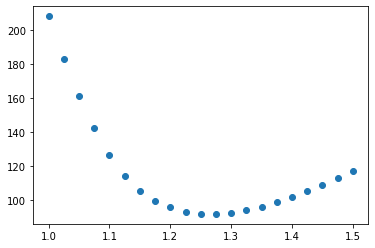

In [188]:
n = 5000

waiting_array = np.zeros(21)
theta_array = np.zeros(21)
for i in range(21):
    theta = 1 + i * 0.025
    mean = c_m
    duetime = 300
    waiting = simulate_all(n, mean * theta, duetime)[0]
    print(f"{theta}: {waiting}")
    waiting_array[i] = waiting
    theta_array[i] = theta

plt.scatter(theta_array, waiting_array)
plt.show()
